In [1]:

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Lambda,Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Sequential  #用來啟動 NN
from tensorflow.keras.layers import Conv2D  # Convolution Operation
from tensorflow.keras.layers import MaxPooling2D # Pooling
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense # Fully Connected Networks
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate, AveragePooling2D, UpSampling2D, add, Multiply, GlobalAveragePooling2D
import tensorflow.keras as keras  
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import os
import random
import re
import time
from random import shuffle

In [2]:
def data_collect(Path):
    files=os.listdir(Path)
    random.shuffle(files)
    Train_Lstm=[]
    Label=[]
    Train=[]
    Train
    count=1
    Train_Pdf=[]
    for file in files:
        start=time.time()
        Break=0
        global Train_pdf, Label_Pdf
        Train_lstm=[]
        file_data=os.listdir(Path+file)
        
        ##CNN_PDF
        #CSFV2
        df_csfv2 = pd.read_csv(Path+file+'/'+file_data[0],header=None)
        df_era5 = pd.read_csv(Path+file+'/'+file_data[1],header=None)
        for column in df_csfv2.columns[2:12]:
            if column == df_csfv2.columns[2]:
                Train_pdf=np.array(np.array(df_csfv2[column]).reshape(61,111,1))
            else:
                Train_pdf=np.append(Train_pdf,np.array(df_csfv2[column]).reshape(61,111,1),axis=2)
                
        #ERAF
        for column in df_era5.columns[2:7]:
            Train_pdf=np.append(Train_pdf,np.array(df_era5[column]).reshape(61,111,1),axis=2)

        ##LSTM
        #ERA5
        df_1 = pd.read_csv(Path+file+'/'+file_data[3])
        for column in df_1.columns[1:91]:
            if' NaN' in list(df_1[column])[:]:
                Break=1
                break
            Train_lstm.append(list(df_1[column]))
            
        #CSFV2
        df_2 = pd.read_csv(Path+file+'/'+file_data[2])
        for column in df_2.columns[1:181]:
            if' NaN' in list(df_2[column])[:]:
                Break=1
                break
            Train_lstm.append(list(df_2[column]))
        if Break==1:
            continue

        ##LABEL_PDF 
        for column in df_era5.columns[7:17]:
            if column == df_era5.columns[7]:
                Label_Pdf=np.array(np.array(df_era5[column]).reshape(61,111,1))
                #print(Label_Pdf)
            else:
                Label_Pdf=np.append(Label_Pdf,np.array(df_era5[column]).reshape(61,111,1),axis=2)

        Train_Pdf.append(Train_pdf)
        Train_Lstm.append(Train_lstm)
        Label.append(Label_Pdf)
        end=time.time()
        Time=(end-start)*(len(files)-count)
        print('%d / %d , Time : %d : %d : %d'%(count,len(files),int(Time/3600),int(Time%3600/60),Time%3600%60),end='\r')
        count=count+1
    Train.append(Train_Pdf)
    Train.append(Train_Lstm)
    Label=np.array(Label)
    return Train,Label

In [3]:
#資料位置
Path='D:/weather/data_180_USA_oneyear/Train/'
#Path_valid='D:/weather/data_180_USA_oneyear/Valid/'

#模型儲存位置
Path_model = 'D:/weather/model_usa/LSMT_Restnet_new_data_my_loss_180days_oneyear(test).h5'

#載入資料
Train,Label=data_collect(Path)

#Valid,Lable_valid=data_collect(Path_valid)

In [4]:
def squeeze_excitation(out_dim, nb_filter):
    def f(input):
        squeeze = GlobalAveragePooling2D()(input)
        excitation = Dense(int(out_dim/2), activation='relu')(squeeze)
        excitation = Dense(out_dim, activation='sigmoid')(excitation)
        excitation = Reshape((1,1,out_dim))(excitation)
        return Multiply()([input, excitation])
    return f


def squeeze_excitation_layer(out_dim, nb_filter):
    def f(input):
        input = squeeze_excitation(out_dim, nb_filter)(input)
        return input
    return f

In [5]:
def Conv2D_BN(inputs,filter,kernel,padding,stride):
    outputs = keras.layers.Conv2D(filters=filter,kernel_size=kernel,padding=padding,strides=stride,activation='relu')(inputs)
    outputs = keras.layers.BatchNormalization()(outputs)
    return outputs

def residual_block(inputs,filter,stride,whether_identity_change=False):
    x = Conv2D_BN(inputs, filter[0], kernel=(1,1), padding='same', stride=stride) 
    x = Conv2D_BN(x, filter[1], kernel=(3,3), padding='same', stride=1)
    x = Conv2D_BN(x, filter[2] ,kernel=(1,1), padding='same', stride=1)
    x = squeeze_excitation_layer(x.shape[-1], x.shape[-1])(x)
  # 累加必须保持尺寸一致，控制恒等层是否需要变channel数和压缩尺寸
    if whether_identity_change:
        identity = Conv2D_BN(inputs, filter[2], kernel=(1,1), padding='same', stride=stride)
        x = keras.layers.add([x,identity])
        return x
    else:
        x = keras.layers.add([x,inputs])
        return x
    
def ResNet():
  inputs = keras.Input(shape=(61, 111, 15))
  x = Conv2D_BN(inputs,64,(7,7),'same',2)
  x = keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)

  x = residual_block(x,[64,64,256],1,True)
  x = residual_block(x,[64,64,256],1)
  x = residual_block(x,[64,64,256],1)

  x = residual_block(x,[128,128,512],2,True)
  x = residual_block(x,[128,128,512],1)
  x = residual_block(x,[128,128,512],1)
  x = residual_block(x,[128,128,512],1)

  x = residual_block(x,[256,256,1024],2,True)
  x = residual_block(x,[256,256,1024],1)
  x = residual_block(x,[256,256,1024],1)
  x = residual_block(x,[256,256,1024],1)
  x = residual_block(x,[256,256,1024],1)
  x = residual_block(x,[256,256,1024],1)

  x = residual_block(x,[512,512,2048],2,True)
  x = residual_block(x,[512,512,2048],1)
  x = residual_block(x,[512,512,2048],1) 
  x = keras.layers.AveragePooling2D(pool_size=(x.shape[1],x.shape[2]))(x)  
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(10000,activation='relu')(x)

  model = keras.Model(inputs=inputs,outputs=x)
  model.summary()
  return model


In [6]:
input_shape = (61, 111, 15)
model_left=ResNet()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 61, 111, 15) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 56, 64)   47104       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 31, 56, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 28, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
input_left = model_left.input
output_left = model_left.output

In [8]:
model_right=Sequential()
model_right.add(LSTM(units = 128, return_sequences = True, input_shape = (270, 10)))#270代表總天數
model_right.add(LSTM(units = 32, return_sequences = True))
model_right.add(Lambda(lambda x: x[-180:, :]))#180代表預測天數
model_right.add(Flatten())
model_right.add(Dense(10000))
model_right.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 270, 128)          71168     
_________________________________________________________________
lstm_1 (LSTM)                (None, 270, 32)           20608     
_________________________________________________________________
lambda (Lambda)              (None, 270, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8640)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 10000)             86410000  
Total params: 86,501,776
Trainable params: 86,501,776
Non-trainable params: 0
_________________________________________________________________


In [9]:
input_right = model_right.input
output_right = model_right.output


In [10]:
# model concat
concatenated = concatenate([output_left, output_right])

In [11]:
x = Dense(10000, activation='relu')(concatenated)
x = Dense(111*61*10, activation='linear')(x)
final_output = Reshape((61,111,10))(x)
model = Model(inputs=[input_left,input_right],outputs=final_output)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 61, 111, 15) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 56, 64)   47104       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 31, 56, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 28, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
#資料轉換格式
Train_Pdf=Train[0]
Train_Lstm=Train[1]
Train_Pdf=np.array(Train_Pdf)
Train_Lstm=np.array(Train_Lstm)
print('Train_Lstm:',Train_Lstm.shape)
print('Train_Pdf:',Train_Pdf.shape)
Train_Pdf_List=Train_Pdf.tolist()

Train_Lstm: (361, 270, 10)
Train_Pdf: (361, 61, 111, 15)


In [13]:
#資料轉換格式
# Valid_Pdf=Valid[0]
# Valid_Lstm=Valid[1]
# Valid_Pdf=np.array(Valid_Pdf)
# Valid_Lstm=np.array(Valid_Lstm)
# print('Valid_Lstm:',Valid_Lstm.shape)
# print('Valid_Pdf:',Valid_Pdf.shape)
# Valid_Pdf_List=Valid_Pdf.tolist()

In [14]:
#儲存最大、最小、平均值
Max=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
Min=[1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]
Mean=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
count=0
for i in range(len(Train_Pdf_List)):
    for j in range(len(Train_Pdf_List[0])):
        for x in range(len(Train_Pdf_List[0][0])):
            for y in range(len(Train_Pdf_List[0][0][0])):
                if Train_Pdf_List[i][j][x][y]>Max[y]:
                    Max[y]=Train_Pdf_List[i][j][x][y]
                if Train_Pdf_List[i][j][x][y]<Min[y]:
                    Min[y]=Train_Pdf_List[i][j][x][y]
                Mean[y]=Mean[y]+Train_Pdf_List[i][j][x][y] 
            count=count+1


In [15]:
Max=Max[:10]
Min=Min[:10]
Mean=Mean[:10]
for i in range(10):
    Mean[i]=Mean[i]/count

In [16]:
print('Mean:',Mean)
print('Max:',Max)
print('Min:',Min)

Mean: [285.3475377672271, 3.970623104767466, 292.8502563692493, 276.0900901464694, -0.29803648920706777, 285.03035332612967, 4.013140157981779, 292.48754398918953, 275.5265458883419, -0.31327538938054805]
Max: [315.1068, 15.8667, 321.9336, 310.6881, 2.9829, 314.5811, 16.2522, 322.6483, 307.9679, 3.1974]
Min: [232.7232, 0.162, 247.7939, 214.6486, -4.6842, 234.7697, 0.1467, 249.058, 213.2278, -4.1766]


In [17]:
def mcustom_loss(y_true, y_pred):

    trueAvg = (y_true[:,:,:,0][:,:,:,np.newaxis]-Mean[0])/(Max[0]-Min[0])
    trueStd = (y_true[:,:,:,1][:,:,:,np.newaxis]-Mean[1])/(Max[1]-Min[1])
    trueMax = (y_true[:,:,:,2][:,:,:,np.newaxis]-Mean[2])/(Max[2]-Min[2])
    trueMin = (y_true[:,:,:,3][:,:,:,np.newaxis]-Mean[3])/(Max[3]-Min[3])
    trueSkw = (y_true[:,:,:,4][:,:,:,np.newaxis]-Mean[4])/(Max[4]-Min[4])

    predAvg = (y_pred[:,:,:,0][:,:,:,np.newaxis]-Mean[0])/(Max[0]-Min[0])
    predStd = (y_pred[:,:,:,1][:,:,:,np.newaxis]-Mean[1])/(Max[1]-Min[1])
    predMax = (y_pred[:,:,:,2][:,:,:,np.newaxis]-Mean[2])/(Max[2]-Min[2])
    predMin = (y_pred[:,:,:,3][:,:,:,np.newaxis]-Mean[3])/(Max[3]-Min[3])
    predSkw = (y_pred[:,:,:,4][:,:,:,np.newaxis]-Mean[4])/(Max[4]-Min[4])
    
    trueAvg_180 = (y_true[:,:,:,5][:,:,:,np.newaxis]-Mean[5])/(Max[5]-Min[5])
    trueStd_180 = (y_true[:,:,:,6][:,:,:,np.newaxis]-Mean[6])/(Max[6]-Min[6])
    trueMax_180 = (y_true[:,:,:,7][:,:,:,np.newaxis]-Mean[7])/(Max[7]-Min[7])
    trueMin_180 = (y_true[:,:,:,8][:,:,:,np.newaxis]-Mean[8])/(Max[8]-Min[8])
    trueSkw_180 = (y_true[:,:,:,9][:,:,:,np.newaxis]-Mean[9])/(Max[9]-Min[9])

    predAvg_180 = (y_pred[:,:,:,5][:,:,:,np.newaxis]-Mean[5])/(Max[5]-Min[5])
    predStd_180 = (y_pred[:,:,:,6][:,:,:,np.newaxis]-Mean[6])/(Max[6]-Min[6])
    predMax_180 = (y_pred[:,:,:,7][:,:,:,np.newaxis]-Mean[7])/(Max[7]-Min[7])
    predMin_180 = (y_pred[:,:,:,8][:,:,:,np.newaxis]-Mean[8])/(Max[8]-Min[8])
    predSkw_180 = (y_pred[:,:,:,9][:,:,:,np.newaxis]-Mean[9])/(Max[9]-Min[9])

    loss = ((K.square(predMin - trueMin) + K.square(predMax - trueMax) + K.square(predSkw - trueSkw) +
            K.square(predAvg - trueAvg) + K.square(predStd - trueStd))+
            (K.square(predMin_180 - trueMin_180) + K.square(predMax_180 - trueMax_180) + K.square(predSkw_180 - trueSkw_180) +
            K.square(predAvg_180 - trueAvg_180) + K.square(predStd_180 - trueStd_180)))/10
    loss = K.mean(loss, axis=-1) 
    
    return loss

In [18]:
model_checkpoint_callback=ModelCheckpoint(Path_model, monitor='val_loss', verbose=1, save_best_only=True)
model.compile(optimizer = 'adam', loss = mcustom_loss,run_eagerly=True)

histroy=model.fit([Train_Pdf,Train_Lstm],Label,
          batch_size=16,
          validation_split=0.2,
          #validation_data=([Valid_Pdf,Valid_Lstm],Lable_valid),
          epochs=100,
          callbacks=[model_checkpoint_callback]
         )

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/18 [==============================] - ETA: 0s - loss: 5.7155
Epoch 00001: val_loss improved from inf to 8.23522, saving model to D:/weather/model_usa\LSMT_Restnet_new_data_my_loss_180days_oneyear(test).h5
18/18 [==============================] - 164s 9s/step - loss: 5.7155 - val_loss: 8.2352
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 0.1589
Epoch 00002: val

18/18 [==============================] - ETA: 0s - loss: 0.0044
Epoch 00031: val_loss did not improve from 0.00560
18/18 [==============================] - 60s 3s/step - loss: 0.0044 - val_loss: 0.0184
Epoch 32/100
18/18 [==============================] - ETA: 0s - loss: 0.0035
Epoch 00032: val_loss did not improve from 0.00560
18/18 [==============================] - 61s 3s/step - loss: 0.0035 - val_loss: 0.0123
Epoch 33/100
18/18 [==============================] - ETA: 0s - loss: 0.0058
Epoch 00033: val_loss did not improve from 0.00560
18/18 [==============================] - 61s 3s/step - loss: 0.0058 - val_loss: 0.0069
Epoch 34/100
18/18 [==============================] - ETA: 0s - loss: 0.0108
Epoch 00034: val_loss did not improve from 0.00560
18/18 [==============================] - 60s 3s/step - loss: 0.0108 - val_loss: 0.0095
Epoch 35/100
18/18 [==============================] - ETA: 0s - loss: 0.0056
Epoch 00035: val_loss did not improve from 0.00560
18/18 [==================

Epoch 67/100
18/18 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00067: val_loss did not improve from 0.00156
18/18 [==============================] - 60s 3s/step - loss: 0.0018 - val_loss: 0.0017
Epoch 68/100
18/18 [==============================] - ETA: 0s - loss: 0.0020
Epoch 00068: val_loss did not improve from 0.00156
18/18 [==============================] - 62s 3s/step - loss: 0.0020 - val_loss: 0.0020
Epoch 69/100
18/18 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00069: val_loss did not improve from 0.00156
18/18 [==============================] - 61s 3s/step - loss: 0.0021 - val_loss: 0.0036
Epoch 70/100
18/18 [==============================] - ETA: 0s - loss: 0.0039
Epoch 00070: val_loss did not improve from 0.00156
18/18 [==============================] - 73s 4s/step - loss: 0.0039 - val_loss: 0.0044
Epoch 71/100
18/18 [==============================] - ETA: 0s - loss: 0.0054
Epoch 00071: val_loss did not improve from 0.00156
18/18 [=====

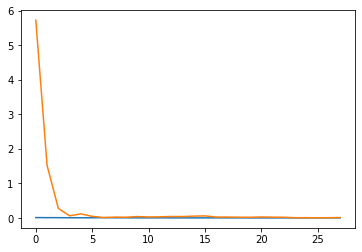

In [19]:
import matplotlib.pyplot as plt
plt.plot(histroy.history['loss'][2:30]) 
plt.plot(histroy.history['val_loss'][2:30]) 